# Part 1

11490434/11490434 [==============================] - 0s 0us/step
Number of training samples: 60000
Dimensions of training data: 28 x 28
Number of test samples: 10000
Dimensions of test data: 28 x 28


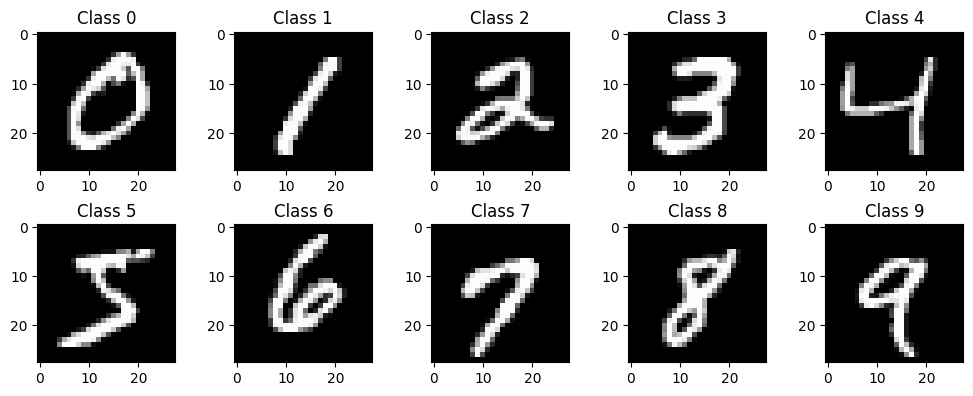

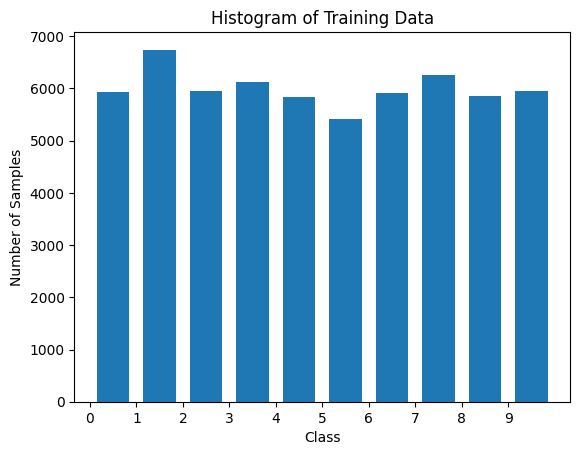

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Get the dimensions of the training and test data
num_train_samples, img_height, img_width = train_images.shape
num_test_samples, _, _ = test_images.shape

print(f"Number of training samples: {num_train_samples}")
print(f"Dimensions of training data: {img_height} x {img_width}")
print(f"Number of test samples: {num_test_samples}")
print(f"Dimensions of test data: {img_height} x {img_width}")

# Create a grid to display sample images
num_rows, num_cols = 2, 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4))

# Display one sample from each class in the grid
classes = list(set(train_labels))
for i, cls in enumerate(classes):
    row, col = i // num_cols, i % num_cols
    sample_index = (train_labels == cls).nonzero()[0][0]
    sample_image = train_images[sample_index]

    axes[row, col].imshow(sample_image, cmap='gray')
    axes[row, col].set_title(f"Class {cls}")

# Remove empty subplots
for i in range(len(classes), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

# Create a histogram of the training data
hist, bins = np.histogram(train_labels, bins=range(11))
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.bar(center, hist, align='center', width=width)
plt.xticks(classes)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Histogram of Training Data')
plt.show()


In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical

# Flatten the images to 2D arrays
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
train_images_scaled = scaler.fit_transform(train_images)
test_images_scaled = scaler.transform(test_images)

# Reshape the images back to their original shape
train_images_scaled = train_images_scaled.reshape(-1, 28, 28)
test_images_scaled = test_images_scaled.reshape(-1, 28, 28)
num_classes = 10
# One-hot encode the labels
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)


# Part 2- teacher model

In [3]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Flatten, Dropout


input_shape=train_images_scaled[0].shape


teacher_model = Sequential()
teacher_model.add(Flatten(input_shape=input_shape))
teacher_model.add(Dense(1024, activation='relu'))
teacher_model.add(Dense(512, activation='relu'))
teacher_model.add(Dense(num_classes, activation=None))
teacher_model.summary()
import keras
opt = keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


teacher_model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
history= teacher_model.fit(train_images_scaled, train_labels , batch_size=32, epochs=20, validation_data=(test_images_scaled, test_labels))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1024)              803840    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 1333770 (5.09 MB)
Trainable params: 1333770 (5.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
1875/1875 [==============================] - 43s 23ms/step - loss: 0.5267 - accuracy: 0.8694 - val_loss: 0.2837 - val_accuracy: 0.9212
Epoc

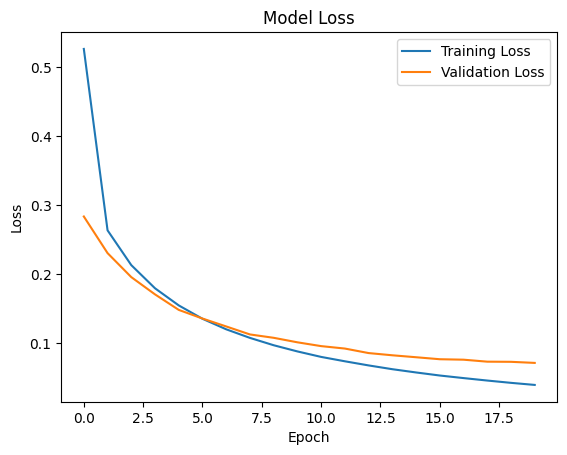

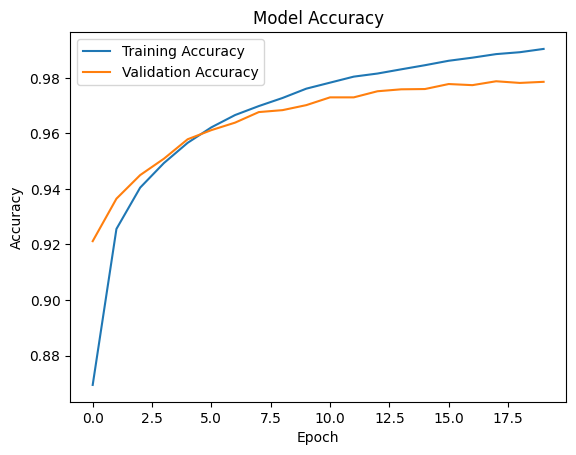

313/313 [==============================] - 2s 5ms/step - loss: 0.0715 - accuracy: 0.9786
Test loss: 0.07151070237159729
Test accuracy: 0.978600025177002


In [4]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss, accuracy = teacher_model.evaluate(test_images_scaled, test_labels, batch_size=32)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


313/313 [==============================] - 2s 5ms/step
Confusion Matrix:


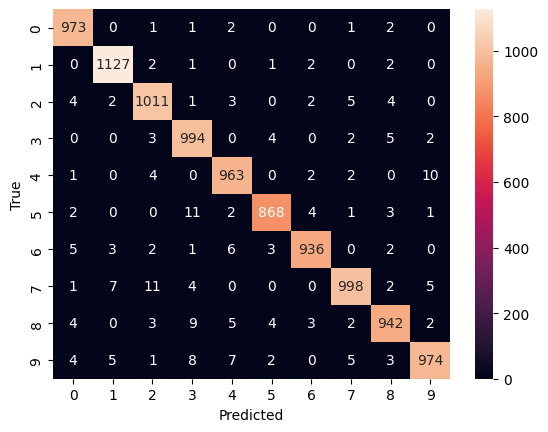

Number of misclassifications: 214


In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = teacher_model.predict(test_images_scaled)
y_pred_bin = np.argmax(y_pred, axis=1)
test_labels_bin = np.argmax(test_labels, axis=1)

cm = confusion_matrix(test_labels_bin, y_pred_bin)
# confusion_matrix()
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# Calculate the number of misclassifications
misclassifications = np.sum(y_pred_bin != test_labels_bin)
print(f"Number of misclassifications: {misclassifications}")

# Part 3- Student model

In [6]:
# Create a new Student Network
student_model = Sequential()
student_model.add(Flatten(input_shape=input_shape))
student_model.add(Dense(128, activation='relu'))
student_model.add(Dense(64, activation='relu'))
student_model.add(Dense(num_classes, activation=None))  # Softmax for the student
student_model.summary()

import keras
opt = keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
student_model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])

# Train the Student Network with Teacher's Logits
history1 = student_model.fit(train_images_scaled, train_labels , batch_size=32, epochs=10, validation_data=(test_images_scaled, test_labels))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6384 - accuracy: 0.8308 - val_loss: 0.3165 - val_accuracy: 0.9114
Ep

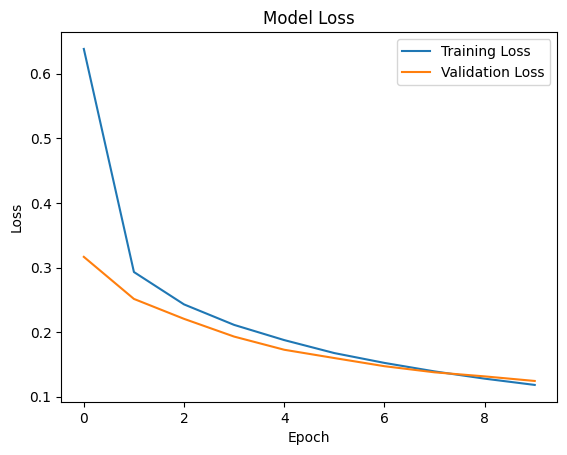

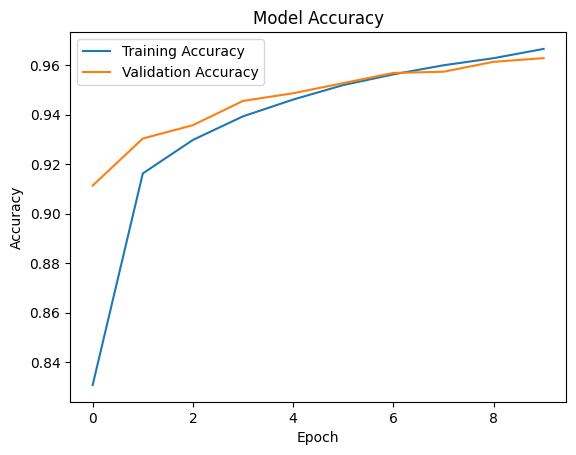

313/313 [==============================] - 1s 2ms/step - loss: 0.1244 - accuracy: 0.9629
Test loss: 0.1243613138794899
Test accuracy: 0.9628999829292297


In [7]:
# Plot the training and validation loss over epochs
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over epochs
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss, accuracy = student_model.evaluate(test_images_scaled, test_labels, batch_size=32)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


313/313 [==============================] - 1s 2ms/step
Confusion Matrix:


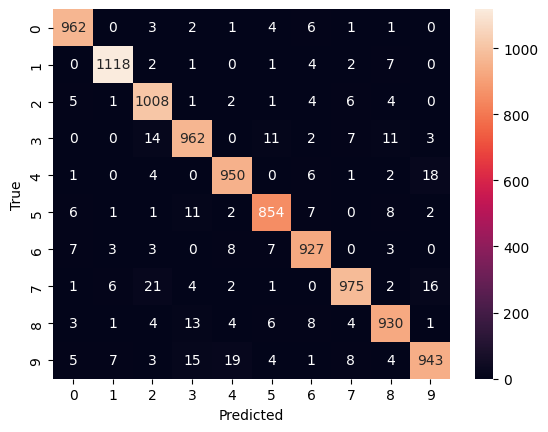

Number of misclassifications: 371


In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = student_model.predict(test_images_scaled)
y_pred_bin = np.argmax(y_pred, axis=1)
test_labels_bin = np.argmax(test_labels, axis=1)

cm = confusion_matrix(test_labels_bin, y_pred_bin)
# confusion_matrix()
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# Calculate the number of misclassifications
misclassifications = np.sum(y_pred_bin != test_labels_bin)
print(f"Number of misclassifications: {misclassifications}")

## with Knowledge Distillation

In [9]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.utils import to_categorical
import tensorflow as tf

input_shape = train_images_scaled[0].shape

# Generate teacher's logits
train_logits = teacher_model.predict(train_images_scaled)
test_logits = teacher_model.predict(test_images_scaled)

student_model = Sequential()
student_model.add(Flatten(input_shape=input_shape))
student_model.add(Dense(128, activation='relu'))
student_model.add(Dense(64, activation='relu'))
student_model.add(Dense(num_classes, activation=None))
student_model.summary()


import keras
opt = keras.optimizers.SGD(learning_rate=0.01)

# tf.keras.losses.mse()

# Use Mean Squared Error (MSE) as the loss function
student_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

# Train the Student Network with Teacher's Logits
history2 = student_model.fit(train_images_scaled, train_logits, batch_size=32, epochs=10, validation_data=(test_images_scaled, test_logits))


313/313 [==============================] - 2s 5ms/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 2.7112 - accura

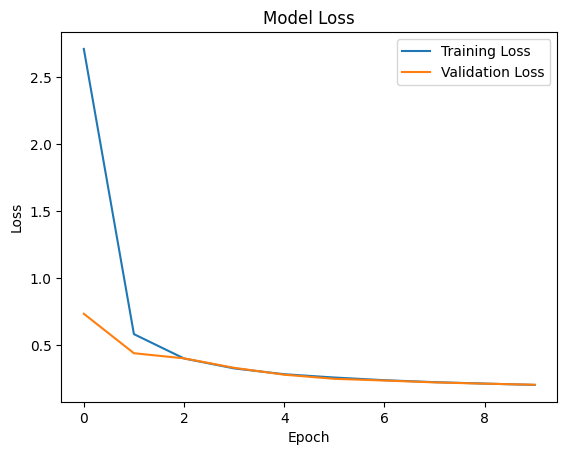

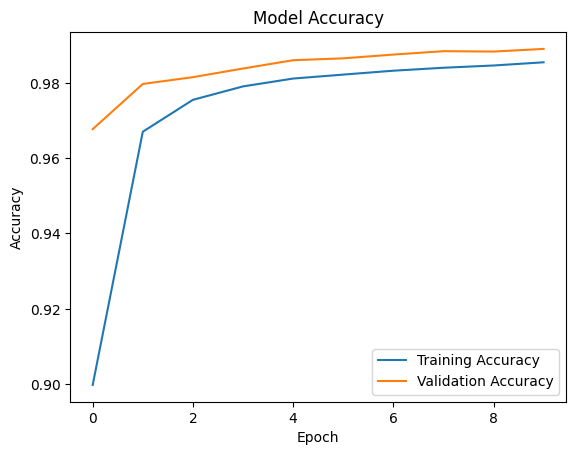

313/313 [==============================] - 1s 2ms/step - loss: 27.2125 - accuracy: 0.9727
Test loss: 27.212493896484375
Test accuracy: 0.9726999998092651


In [10]:
# Plot the training and validation loss over epochs
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over epochs
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss, accuracy = student_model.evaluate(test_images_scaled, test_labels, batch_size=32)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


313/313 [==============================] - 1s 2ms/step
Confusion Matrix:


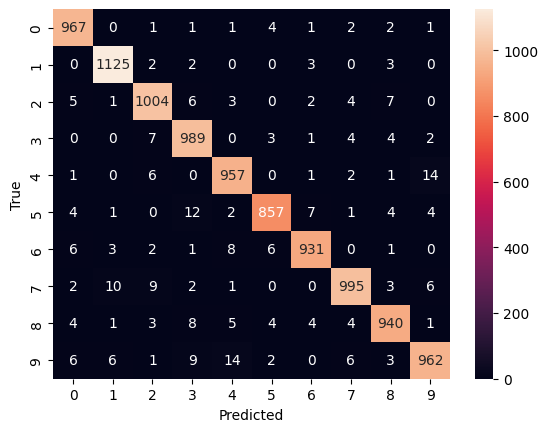

Number of misclassifications: 273


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = student_model.predict(test_images_scaled)
y_pred_bin = np.argmax(y_pred, axis=1)
test_labels_bin = np.argmax(test_labels, axis=1)

cm = confusion_matrix(test_labels_bin, y_pred_bin)
# confusion_matrix()
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# Calculate the number of misclassifications
misclassifications = np.sum(y_pred_bin != test_labels_bin)
print(f"Number of misclassifications: {misclassifications}")

## Compare

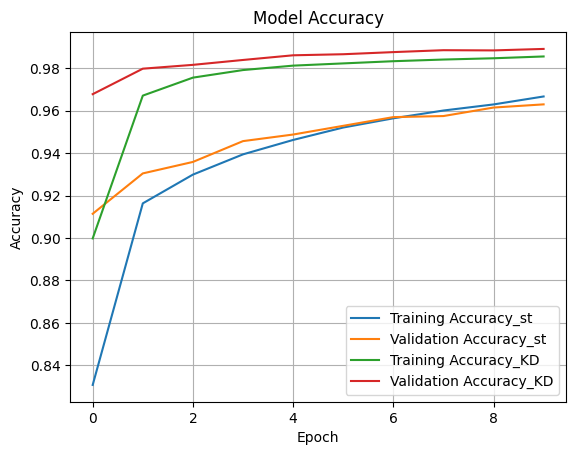

In [13]:

plt.plot(history1.history['accuracy'], label='Training Accuracy_st')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy_st')

plt.plot(history2.history['accuracy'], label='Training Accuracy_KD')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy_KD')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

